# Notebook con resultados

## Imports

In [3]:
from seaborn import load_dataset
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting

In [4]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

## Creación de DataFrames

In [5]:
storage = HDF5FeatureStorage("./test.hdf5")
df_fc = storage.read_df('BOLD_parccortical-TianxS3x3TxMNI6thgeneration')
df_alff = storage.read_df('BOLD_ALFF_parccortical-TianxS3x3TxMNI6thgeneration')
df_participants = pd.read_csv("./participants.tsv", sep="\t")
df_participants.rename(columns={"participant_id": "subject"}, inplace=True)
df_participants.set_index("subject", inplace=True)
parcellation_labels = df_alff.columns.values

In [7]:
df_alff_full = df_alff.merge(df_participants, on="subject")
df_fc_full = df_fc.merge(df_participants, on="subject")

## Conectividad funcional promedio por cada grupo de sujetos

<Figure size 1000x800 with 0 Axes>

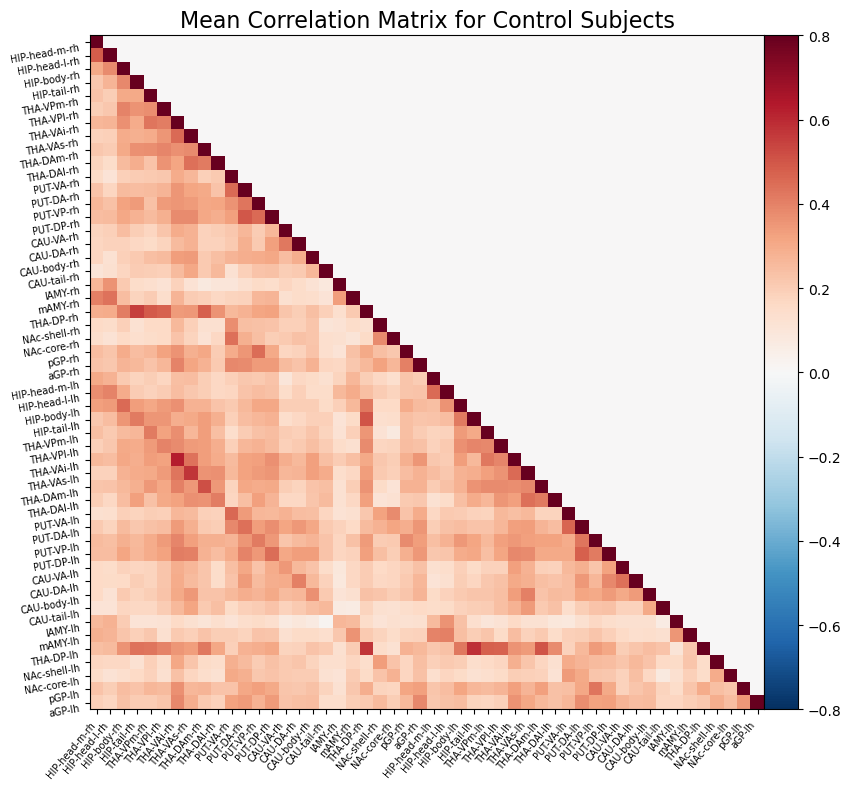

<Figure size 1000x800 with 0 Axes>

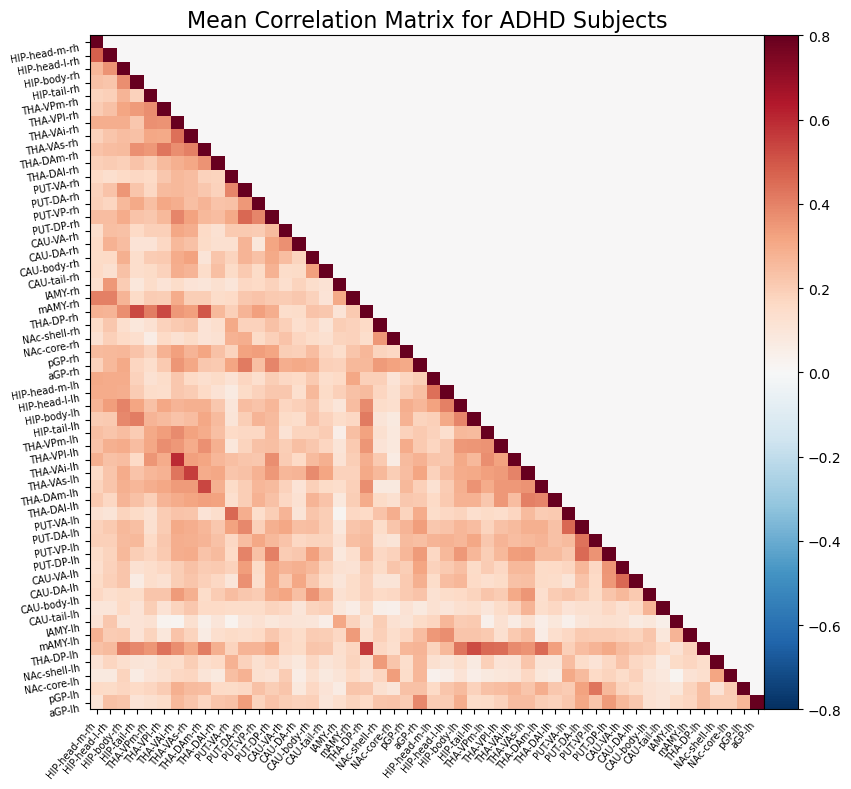

<Figure size 1000x800 with 0 Axes>

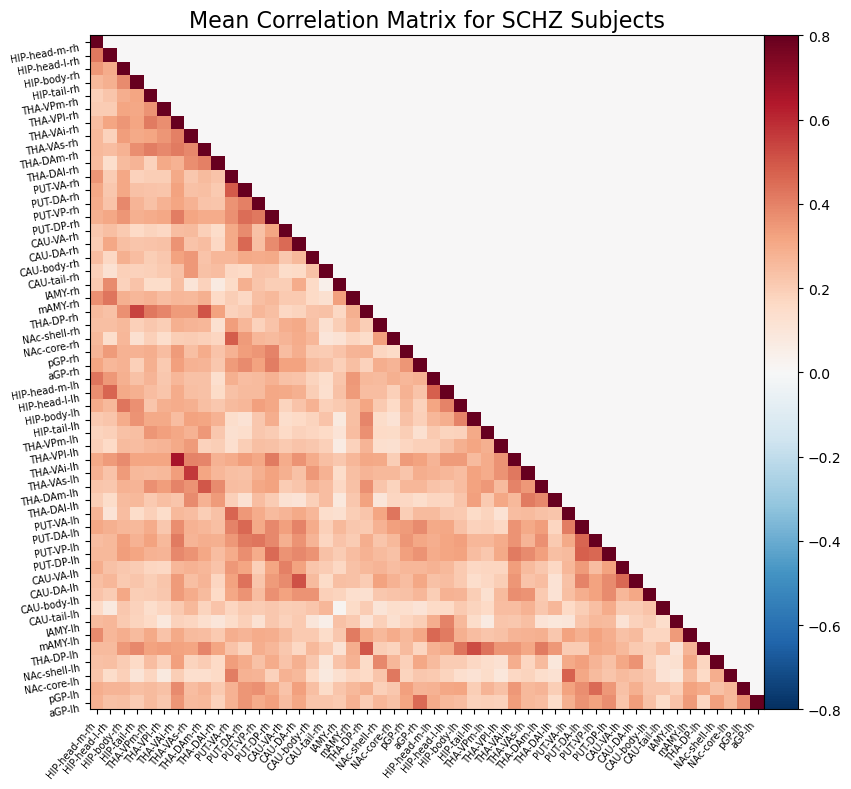

In [8]:
def plot_correlation_matrix(lower_tri_array, parcellation, title="Correlation Matrix"):
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    corr_matrix = np.zeros((n, n))
    
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array

    plt.figure(figsize=(10, 8))
    plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=parcellation, colorbar=True, vmax=0.8, vmin=-0.8, title=title)
    plt.show()

# Get the mean value of the correlation matrix for all subjects with diagnosis AD
lower_mean_control = df_fc_full[df_fc_full['diagnosis'] == 'CONTROL'][df_fc.columns].mean().values
lower_mean_adhd = df_fc_full[df_fc_full['diagnosis'] == 'ADHD'][df_fc.columns].mean().values
lower_mean_schz = df_fc_full[df_fc_full['diagnosis'] == 'SCHZ'][df_fc.columns].mean().values

plot_correlation_matrix(lower_mean_control, parcellation=parcellation_labels, title="Mean Correlation Matrix for Control Subjects")
plot_correlation_matrix(lower_mean_adhd, parcellation=parcellation_labels, title="Mean Correlation Matrix for ADHD Subjects")
plot_correlation_matrix(lower_mean_schz, parcellation=parcellation_labels, title="Mean Correlation Matrix for SCHZ Subjects")


## Exploración con distintos modelos

In [9]:
es_control = lambda x: 1 if x =="CONTROL" else 0
df_fc_full["is_control"] = df_fc_full["diagnosis"].apply(es_control)
df_alff_full["is_control"] = df_alff_full["diagnosis"].apply(es_control)

In [10]:
df_fc_dev, df_fc_test = train_test_split(df_fc_full, test_size=0.2, stratify=df_fc_full["is_control"])
df_alff_dev, df_alff_test = df_alff_full.loc[df_fc_dev.index], df_alff_full.loc[df_fc_test.index]

x_fc_cols, x_alff_cols, target = list(df_fc.columns), list(df_alff.columns),  "is_control" 

### Hacemos PCA para reducir la dimensionalidad de los datos (de ~1200 a 100 columnas)

In [11]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
X_fc_dev = df_fc_dev
pca = PCA(n_components=50)
X_fc_dev_pca = pca.fit_transform(X_fc_dev[x_fc_cols])

In [12]:
df_fc_dev_pca = pd.DataFrame(X_fc_dev_pca, columns = list([str(x) for x in range(X_fc_dev_pca.shape[1])]), index=df_fc_dev.index)
df_fc_dev_pca_cols = list(df_fc_dev_pca.columns)
df_fc_dev_pca[target] = df_fc_dev[target].values

### SVM:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide

In [13]:
def creator(model_name, hyperparams):
    creator_ = PipelineCreator(problem_type="classification")
    creator_.add("zscore")
    creator_ .add(model_name, **hyperparams)
    return creator_

In [14]:
creator_svm_lin = creator("svm", {"kernel":"linear", "C":np.logspace(-3,3,20)})

In [15]:
def nested_cv(col_names, target_name, data, model):
    scores_fc_pca, model_svm_fc_pca, inspector_fc_pca = run_cross_validation(
    X=col_names,
    y=target_name,
    data = data,
    model=model,
    cv=cv,
    return_inspector=True,
    return_train_score=True,
    return_estimator="all",
    search_params={"cv":StratifiedKFold(n_splits=5)},
    scoring = "roc_auc"
)
    return scores_fc_pca, model_svm_fc_pca, inspector_fc_pca

In [16]:
explor_hyperparams_df = pd.DataFrame()

In [17]:
scores_fc_svm_lin, model_svm_fc_lin, inspector_fc_svm_lin = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_lin)

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

In [18]:
explor_hyperparams_df["svm_lin"] = scores_fc_svm_lin["test_score"]

In [19]:
creator_svm_rbf = creator("svm", {"kernel":"rbf", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_rbf, model_svm_fc_rbf, inspector_fc_svm_rbf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_rbf)

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

In [20]:
explor_hyperparams_df["svm_rbf"] = scores_fc_svm_rbf["test_score"]

In [21]:
creator_svm_sigmoid = creator("svm", {"kernel":"sigmoid", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_sigmoid, model_svm_fc_sigmoid, inspector_fc_svm_sigmoid = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_sigmoid)
explor_hyperparams_df["svm_sigmoid"] = scores_fc_svm_sigmoid["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

### Random Forests XGBoost

In [23]:
creator_rf= creator("rf", {"n_estimators":[10,30,70,100,200], "max_depth":[None,5,25,50]})
scores_fc_rf, model_fc_rf, inspector_fc_rf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_rf)
explor_hyperparams_df["rf"] = scores_fc_rf["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

In [24]:
explor_hyperparams_df

,svm_lin,svm_rbf,svm_sigmoid,rf
0,0.423913,0.534783,0.381522,0.339130
1,0.400000,0.645652,0.428261,0.429348
2,0.384783,0.278261,0.515217,0.376087
3,0.452381,0.354978,0.448052,0.411255
4,0.472727,0.543182,0.504545,0.640909


In [28]:
from xgboost import XGBClassifier
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 25],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 0.01,1]
}
xgboost = XGBClassifier()

In [30]:
#creator_xgb = creator(xgboost, xgb_param_grid)
#scores_fc_xgb, model_fc_xgb, inspector_fc_xgb = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_xgb)
#explor_hyperparams_df["xgb"] = scores_fc_xgb["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

KeyboardInterrupt: 

In [43]:
creator_dummy= creator("dummy", {})
scores_fc_dummy, model_fc_dummy, inspector_fc_dummy = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_dummy)
explor_hyperparams_df["dummy"] = scores_fc_dummy["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'

In [44]:
explor_hyperparams_df

,svm_lin,svm_rbf,svm_sigmoid,rf,dummy
0,0.423913,0.534783,0.381522,0.339130,0.5
1,0.400000,0.645652,0.428261,0.429348,0.5
2,0.384783,0.278261,0.515217,0.376087,0.5
3,0.452381,0.354978,0.448052,0.411255,0.5
4,0.472727,0.543182,0.504545,0.640909,0.5


In [46]:
import matplotlib.pyplot as plt 
plt.style.use("ggplot")

<Axes: >

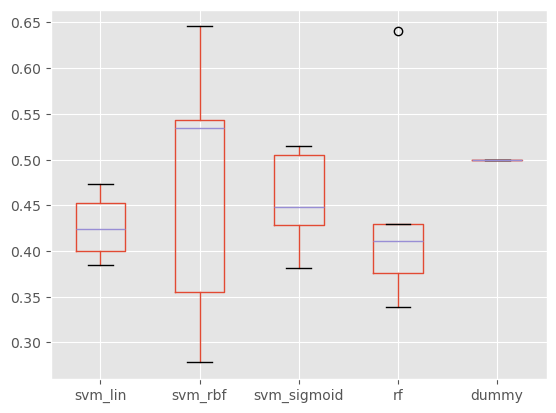

In [47]:
explor_hyperparams_df.boxplot()

In [63]:
modelo_final = model_svm_fc_sigmoid.best_estimator_

In [72]:
df_fc.columns

Index(['HIP-head-m-rh~HIP-head-m-rh', 'HIP-head-l-rh~HIP-head-m-rh',
       'HIP-head-l-rh~HIP-head-l-rh', 'HIP-body-rh~HIP-head-m-rh',
       'HIP-body-rh~HIP-head-l-rh', 'HIP-body-rh~HIP-body-rh',
       'HIP-tail-rh~HIP-head-m-rh', 'HIP-tail-rh~HIP-head-l-rh',
       'HIP-tail-rh~HIP-body-rh', 'HIP-tail-rh~HIP-tail-rh',
       ...
       'aGP-lh~CAU-DA-lh', 'aGP-lh~CAU-body-lh', 'aGP-lh~CAU-tail-lh',
       'aGP-lh~lAMY-lh', 'aGP-lh~mAMY-lh', 'aGP-lh~THA-DP-lh',
       'aGP-lh~NAc-shell-lh', 'aGP-lh~NAc-core-lh', 'aGP-lh~pGP-lh',
       'aGP-lh~aGP-lh'],
      dtype='object', length=1275)

In [73]:
X_test, y_test = df_fc_test.drop(columns=["is_control"])[df_fc.columns], df_fc_test["is_control"]

In [76]:
X_test = pca.fit_transform(X_test)

ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=54 with svd_solver='full'

### Random Forest utilizando ALFF

In [44]:
creator_rf_alff = PipelineCreator(problem_type="classification")
creator_rf_alff.add("zscore")
creator_rf_alff.add("rf", n_estimators=[25,50,100,200], max_depth=[None, 5, 10, 20])

In [54]:
scores, model, inspector = run_cross_validation(
    X= x_alff_cols,
    y=target,
    data = df_alff_dev,
    model=creator_rf_alff,
    cv=cv,
    return_train_score=True,
    return_estimator="all",
    search_params={"cv":StratifiedKFold(n_splits=5)},
    return_inspector=True,
    scoring = "roc_auc"
)

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

In [55]:
scores

,fit_time,score_time,estimator,test_score,train_score,n_train,n_test,repeat,fold,cv_mdsum
0,10.429352,0.005238,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.589827,1.0,171,43,0,0,4bbff3df81cf8854822a1b557f37a710
1,10.833624,0.013769,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.560870,1.0,171,43,0,1,4bbff3df81cf8854822a1b557f37a710
2,10.549078,0.004918,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.600000,1.0,171,43,0,2,4bbff3df81cf8854822a1b557f37a710
3,10.636809,0.004516,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.619565,1.0,171,43,0,3,4bbff3df81cf8854822a1b557f37a710
4,10.881558,0.009613,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...",0.475000,1.0,172,42,0,4,4bbff3df81cf8854822a1b557f37a710
